

# Predicting 2023 Women's March Madness

### Data Analysis for Draft King's

Ash Heinke

## Overview



## Business Problem


# Exploratory Data Analysis

## Data Understanding


In [112]:
import numpy as np
import pandas as pd
import xlrd
import os
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV,\
cross_val_score, KFold
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier,\
ExtraTreesClassifier, VotingClassifier, StackingRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder,\
OrdinalEncoder, MaxAbsScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, recall_score, f1_score,\
accuracy_score, classification_report, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from xgboost import XGBRegressor
from xgboost import XGBClassifier
import xgboost as xgb
from matplotlib import pyplot as plt
import warnings

## Importing Datasets

### WNCAA Regular Season Detailed Results Dataset

This data includes game-by-game stats at a team level (free throws attempted, defensive rebounds, turnovers, etc.) for all regular season, conference tournament, and NCAA® tournament games since the 2009-10 season.

For each season, the file includes all games played from DayNum 0 through 132. The "Regular Season" games are simply defined to be all games played on DayNum = 132 or earlier (DayNum = 132 is Selection Sunday, and there are always a few conference tournament finals actually played early in the day on Selection Sunday itself). Thus a game played on or before Selection Sunday will show up here whether it was a pre-season tournament, a non-conference game, a regular conference game, a conference tournament game, etc.

Each of the columns is described below, noting that a "W" or "L" refers to the winning or losing team:

- 'Season': this is the year in which the final tournament occurs. For example, during the 2016 season, there were regular season games played between November 2015 and March 2016, and all of those games will show up with a Season of 2016.
- 'DayNum': this integer always ranges from 0 to 132, and tells you what day the game was played on. It represents an offset from the "DayZero" date. For example, the first game was DayNum = 11, which means it occured 11 days into the season from day zero.
- 'WTeamID': this identifies the id number of the team that won the game, whether the game was won by the home team or visiting team, or if it was a neutral-site game.
- 'WScore': this identifies the number of points scored by the winning team.
- 'LTeamID': this identifies the id number of the team that lost the game.
- 'LScore': this identifies the number of points scored by the losing team. Thus you can be confident that WScore will be greater than LScore for all games listed.
- 'WLoc': this identifies the "location" of the winning team. If the winning team was the home team, this value will be "H". If the winning team was the visiting (or "away") team, this value will be "A". If it was played on a neutral court, then this value will be "N". 
- 'NumOT': this indicates the number of overtime periods in the game, an integer 0 or higher.

- 'WFGM': field goals made (by the winning team)
- 'WFGA': field goals attempted (by the winning team)
- 'WFGM3': three pointers made (by the winning team)
- 'WFGA3': three pointers attempted (by the winning team)
- 'WFTM': free throws made (by the winning team)
- 'WFTA': free throws attempted (by the winning team)
- 'WOR': offensive rebounds (pulled by the winning team)
- 'WDR': defensive rebounds (pulled by the winning team)
- 'WAst': assists (by the winning team)
- 'WTO': turnovers committed (by the winning team)
- 'WStl': steals (accomplished by the winning team)
- 'WBlk': blocks (accomplished by the winning team)
- 'WPF': personal fouls committed (by the winning team)

*The same set of stats from the perspective of the losing team: LFGM is the number of field goals made by the losing team, and so on up to LPF.

Note: by convention, "field goals made" (either WFGM or LFGM) refers to the total number of field goals made by a team, a combination of both two-point field goals and three-point field goals, however, "three point field goals made" (either WFGM3 or LFGM3) is just the three-point fields goals made. So to calculate two-point field goals, you have to subtract one from the other (e.g., WFGM - WFGM3). The total number of points scored is 2 * FGM + FGM3 + FTM.

In [113]:
# Importing CSV of NCAAW regular season team data, pulled from Kaggle
season_df = pd.read_csv('/Users/aheinke/Documents/Flatiron/NYC-DS-010923/Phase_3/Phase3_Proj/PROJ_CSVs/WRegularSeasonDetailedResults.csv')
season_df

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2010,11,3103,63,3237,49,H,0,23,54,...,13,6,10,11,27,11,23,7,6,19
1,2010,11,3104,73,3399,68,N,0,26,62,...,21,14,27,14,26,7,20,4,2,27
2,2010,11,3110,71,3224,59,A,0,29,62,...,14,19,23,17,23,8,15,6,0,15
3,2010,11,3111,63,3267,58,A,0,27,52,...,26,16,25,22,22,15,11,14,5,14
4,2010,11,3119,74,3447,70,H,1,30,74,...,17,11,21,21,32,12,14,4,2,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70002,2023,113,3268,96,3234,68,H,0,34,71,...,38,11,15,18,19,14,24,5,3,14
70003,2023,113,3385,69,3163,64,A,0,23,63,...,21,12,15,11,25,14,12,5,7,19
70004,2023,113,3416,57,3396,53,H,0,19,60,...,26,14,17,16,19,5,9,10,9,20
70005,2023,113,3437,67,3177,64,H,0,24,67,...,19,8,11,21,26,13,12,9,2,14


In [114]:
# Checking CSV info
season_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70007 entries, 0 to 70006
Data columns (total 34 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Season   70007 non-null  int64 
 1   DayNum   70007 non-null  int64 
 2   WTeamID  70007 non-null  int64 
 3   WScore   70007 non-null  int64 
 4   LTeamID  70007 non-null  int64 
 5   LScore   70007 non-null  int64 
 6   WLoc     70007 non-null  object
 7   NumOT    70007 non-null  int64 
 8   WFGM     70007 non-null  int64 
 9   WFGA     70007 non-null  int64 
 10  WFGM3    70007 non-null  int64 
 11  WFGA3    70007 non-null  int64 
 12  WFTM     70007 non-null  int64 
 13  WFTA     70007 non-null  int64 
 14  WOR      70007 non-null  int64 
 15  WDR      70007 non-null  int64 
 16  WAst     70007 non-null  int64 
 17  WTO      70007 non-null  int64 
 18  WStl     70007 non-null  int64 
 19  WBlk     70007 non-null  int64 
 20  WPF      70007 non-null  int64 
 21  LFGM     70007 non-null  int64 
 22

In [115]:
# Looking further at the decriptions of the data to see if there is anything that stands out
season_df.describe()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,NumOT,WFGM,WFGA,WFGM3,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
count,70007.000000,70007.000000,70007.000000,70007.000000,70007.000000,70007.000000,70007.000000,70007.000000,70007.000000,70007.000000,...,70007.000000,70007.000000,70007.000000,70007.000000,70007.000000,70007.000000,70007.000000,70007.000000,70007.000000,70007.000000
mean,2016.363121,69.732684,3284.464468,71.560087,3285.842016,57.197809,0.051966,25.768537,58.955790,6.192224,...,17.769294,10.548617,15.618595,11.764109,22.678218,10.941749,17.293056,7.133058,2.842744,18.160184
std,3.972433,35.822635,103.679278,11.507045,104.902400,10.998869,0.259630,4.969290,7.996305,3.102889,...,6.464240,4.953425,6.660786,4.625909,4.929788,3.804759,5.294115,3.201616,2.076047,4.716219
min,2010.000000,1.000000,3101.000000,30.000000,3101.000000,11.000000,0.000000,9.000000,30.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,2013.000000,37.000000,3196.000000,64.000000,3194.000000,50.000000,0.000000,22.000000,53.000000,4.000000,...,13.000000,7.000000,11.000000,8.000000,19.000000,8.000000,14.000000,5.000000,1.000000,15.000000
50%,2016.000000,73.000000,3283.000000,71.000000,3286.000000,57.000000,0.000000,25.000000,59.000000,6.000000,...,17.000000,10.000000,15.000000,11.000000,23.000000,11.000000,17.000000,7.000000,2.000000,18.000000
75%,2020.000000,101.000000,3376.000000,79.000000,3375.000000,64.000000,0.000000,29.000000,64.000000,8.000000,...,22.000000,14.000000,20.000000,15.000000,26.000000,13.000000,21.000000,9.000000,4.000000,21.000000
max,2023.000000,132.000000,3477.000000,140.000000,3477.000000,130.000000,5.000000,58.000000,113.000000,25.000000,...,80.000000,37.000000,52.000000,38.000000,53.000000,34.000000,49.000000,26.000000,17.000000,47.000000


Some interesting findings here!
- The lowest score ever in a season since 2010 for a losing team was 11 points? In comparison a team has won with only 30 points...
- There have been a game/games with 5 overtimes!
- It is interesting that certain stats could have a minimum of 0 (no assists, three point attempts, etc??) This could mean that we have some missing data that we will need to deal with...
We're going to be utilizing various calculations, especially the mean, for a lot of these statistics, so this may help resolve some of the data that seems funny.

In [116]:
# Checking for null values, and it seems that we have none!
season_df.isna().sum()

Season     0
DayNum     0
WTeamID    0
WScore     0
LTeamID    0
LScore     0
WLoc       0
NumOT      0
WFGM       0
WFGA       0
WFGM3      0
WFGA3      0
WFTM       0
WFTA       0
WOR        0
WDR        0
WAst       0
WTO        0
WStl       0
WBlk       0
WPF        0
LFGM       0
LFGA       0
LFGM3      0
LFGA3      0
LFTM       0
LFTA       0
LOR        0
LDR        0
LAst       0
LTO        0
LStl       0
LBlk       0
LPF        0
dtype: int64

### WNCAA Tourney Detailed Results Dataset

This dataset provides team-level, game-by-game NCAA® tournament results for all seasons of historical data, starting with the 2010 season. Note that this tournament game data also includes the play-in games for the years that had them, so each season you will see between 63 and 67 games listed, depending on how many play-in games there were.

Even with the somewhat varied structure of the women's tournament schedule, you can generally tell what round a game was, depending on the DayNum. In general the schedule will be:

- DayNum = 134 or 135 (Tue/Wed): play-in games to get the tournament field down to the final 64 teams
- DayNum = 136 or 137 (Thu/Fri): Round 1, to bring the tournament field from 64 teams to 32 teams
- DayNum = 138 or 139 (Sat/Sun): Round 2, to bring the tournament field from 32 teams to 16 teams
- DayNum = 143 or 144 (Thu/Fri): Round 3, the "Sweet Sixteen", to bring the tournament field from 16 teams to 8 teams
- DayNum = 145 or 146 (Sat/Sun): Round 4, known as the "Elite Eight" or "regional finals", to bring the tournament field from 8 teams to 4 teams
- DayNum = 152 (Sat): Round 5, known as the "Final Four" or "national semifinals", to bring the tournament field from 4 teams to 2 teams
- DayNum = 154 (Mon): Round 6, known as the "national final" or "national championship", to bring the tournament field from 2 teams to 1 champion team

In [117]:
# Pullng in the tournament data, which is also from Kaggle
tourney_df = pd.read_csv('/Users/aheinke/Documents/Flatiron/NYC-DS-010923/Phase_3/Phase3_Proj/PROJ_CSVs/WNCAATourneyDetailedResults.csv')
tourney_df

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2010,138,3124,69,3201,55,N,0,28,57,...,34,3,5,17,19,12,18,4,1,18
1,2010,138,3173,67,3395,66,N,0,23,59,...,27,14,15,18,26,8,8,8,6,22
2,2010,138,3181,72,3214,37,H,0,26,57,...,15,3,8,10,21,4,16,6,4,20
3,2010,138,3199,75,3256,61,H,0,25,63,...,20,17,22,16,21,13,16,5,4,24
4,2010,138,3207,62,3265,42,N,0,24,68,...,26,11,17,16,22,9,10,3,4,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,2022,147,3163,91,3301,87,N,2,37,77,...,23,16,19,6,30,20,13,4,7,16
756,2022,147,3257,62,3276,50,N,0,25,58,...,14,15,20,10,24,9,21,6,2,12
757,2022,151,3163,63,3390,58,N,0,21,57,...,23,8,13,11,23,10,11,11,3,16
758,2022,151,3376,72,3257,59,N,0,27,57,...,8,4,7,11,18,5,15,13,2,17


In [118]:
final_four22 = top_four = tourney_df[(tourney_df['Season'] == 2022) & (tourney_df['DayNum'] > \
                                            150)].sort_values(by='WTeamID', ascending=False).head(4)
final_four22

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
758,2022,151,3376,72,3257,59,N,0,27,57,...,8,4,7,11,18,5,15,13,2,17
759,2022,153,3376,64,3163,49,N,0,22,60,...,16,1,4,3,16,14,14,4,5,21
757,2022,151,3163,63,3390,58,N,0,21,57,...,23,8,13,11,23,10,11,11,3,16


In [119]:
final_four22.rename(columns = {'WTeamID': 'TeamID'}, inplace = True)
final_four22 = final_four22.sort_values(by = 'DayNum', ascending = True)
final_four22

,Season,DayNum,TeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
758,2022,151,3376,72,3257,59,N,0,27,57,...,8,4,7,11,18,5,15,13,2,17
757,2022,151,3163,63,3390,58,N,0,21,57,...,23,8,13,11,23,10,11,11,3,16
759,2022,153,3376,64,3163,49,N,0,22,60,...,16,1,4,3,16,14,14,4,5,21


In [120]:
final_four21 = top_four = tourney_df[(tourney_df['Season'] == 2021) & (tourney_df['DayNum'] > \
                                            150)].sort_values(by='WTeamID', ascending=False).head(4)
final_four21

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
691,2021,151,3390,66,3376,65,N,0,25,60,...,20,8,12,18,17,9,11,6,5,15
692,2021,153,3390,54,3112,53,N,0,24,57,...,22,13,18,5,22,5,6,12,2,11
690,2021,151,3112,69,3163,59,N,0,20,50,...,12,14,20,4,27,11,12,4,2,23


In [121]:
final_four21.rename(columns = {'WTeamID': 'TeamID'}, inplace = True)
final_four21 = final_four21.sort_values(by = 'DayNum', ascending = True)
final_four21

,Season,DayNum,TeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
691,2021,151,3390,66,3376,65,N,0,25,60,...,20,8,12,18,17,9,11,6,5,15
690,2021,151,3112,69,3163,59,N,0,20,50,...,12,14,20,4,27,11,12,4,2,23
692,2021,153,3390,54,3112,53,N,0,24,57,...,22,13,18,5,22,5,6,12,2,11


In [122]:
top_16_teams = tourney_df['WTeamID'].value_counts().head(16)
top_16_teams

3163    59
3323    44
3390    43
3124    39
3376    32
3257    30
3397    24
3268    23
3401    21
3280    18
3181    18
3246    18
3199    16
3400    16
3333    14
3328    13
Name: WTeamID, dtype: int64

In [123]:
top_16_teams = top_16_teams.reset_index()
top_16_teams

,index,WTeamID
0,3163,59
1,3323,44
2,3390,43
3,3124,39
4,3376,32
5,3257,30
6,3397,24
7,3268,23
8,3401,21
9,3280,18


In [124]:
top_16_teams.rename(columns = {'index': 'TeamID', 'WTeamID': 'NumGames'}, inplace = True)
top_16_teams

,TeamID,NumGames
0,3163,59
1,3323,44
2,3390,43
3,3124,39
4,3376,32
5,3257,30
6,3397,24
7,3268,23
8,3401,21
9,3280,18


In [125]:
# Now pulling in a new CSV which lists all of the NCAAW teams and their TeamIDs. Also pulled from Kaggle.
# This corresponds to our previous datasets so that we can match the teams by their ID
teams_df = pd.read_csv('/Users/aheinke/Documents/Flatiron/NYC-DS-010923/Phase_3/Phase3_Proj/PROJ_CSVs/WTeams.csv')
teams_df

,TeamID,TeamName
0,3101,Abilene Chr
1,3102,Air Force
2,3103,Akron
3,3104,Alabama
4,3105,Alabama A&M
...,...,...
370,3473,Lindenwood
371,3474,Queens NC
372,3475,Southern Indiana
373,3476,Stonehill


In [126]:
teams_df2 = teams_df.copy()

In [127]:
teams_df2.rename(columns = {'TeamID': 'LTeamID'}, inplace = True)
teams_df2

,LTeamID,TeamName
0,3101,Abilene Chr
1,3102,Air Force
2,3103,Akron
3,3104,Alabama
4,3105,Alabama A&M
...,...,...
370,3473,Lindenwood
371,3474,Queens NC
372,3475,Southern Indiana
373,3476,Stonehill


In [128]:
team_name = teams_df.loc[teams_df['TeamID'] == 3163, 'TeamName'].iloc[0]
team_name

'Connecticut'

In [129]:
# Making a dictionary from the dataset so that we can pull the team names when needed
team_dict = dict(zip(teams_df['TeamID'], teams_df['TeamName']))
team_dict

TypeError: 'dict' object is not callable

In [130]:
tourney_df2 = tourney_df.rename(columns = team_dict, inplace = True)
tourney_df2

In [143]:
final_four21_teams = pd.merge(final_four21, teams_df, how = 'left', on = ['TeamID'])
final_four21_teams

,Season,DayNum,TeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,TeamName
0,2021,151,3390,66,3376,65,N,0,25,60,...,8,12,18,17,9,11,6,5,15,Stanford
1,2021,151,3112,69,3163,59,N,0,20,50,...,14,20,4,27,11,12,4,2,23,Arizona
2,2021,153,3390,54,3112,53,N,0,24,57,...,13,18,5,22,5,6,12,2,11,Stanford


In [149]:
final_four21_teams2 = final_four21_teams.loc[:, ['Season', 'DayNum', 'TeamName', 'WScore']]
final_four21_teams2

,Season,DayNum,TeamName,WScore
0,2021,151,Stanford,66
1,2021,151,Arizona,69
2,2021,153,Stanford,54


In [145]:
final_four21_teamsa = pd.merge(final_four21, teams_df2, how = 'left', on = ['LTeamID'])
final_four21_teamsa

,Season,DayNum,TeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,TeamName
0,2021,151,3390,66,3376,65,N,0,25,60,...,8,12,18,17,9,11,6,5,15,South Carolina
1,2021,151,3112,69,3163,59,N,0,20,50,...,14,20,4,27,11,12,4,2,23,Connecticut
2,2021,153,3390,54,3112,53,N,0,24,57,...,13,18,5,22,5,6,12,2,11,Arizona


In [146]:
final_four21_teams3 = final_four21_teamsa.loc[:, ['Season', 'DayNum', 'TeamName', 'LScore']]
final_four21_teams3

,Season,DayNum,TeamName,LScore
0,2021,151,South Carolina,65
1,2021,151,Connecticut,59
2,2021,153,Arizona,53


In [151]:
wfinal_four22 = pd.concat(final_four21_teamsa, final_four21_teams3)
wfinal_four22

TypeError: first argument must be an iterable of pandas objects, you passed an object of type "DataFrame"

In [152]:
final_four22_teams = pd.merge(final_four22, teams_df, how = 'left', on = ['TeamID'])
final_four22_teams

,Season,DayNum,TeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,TeamName
0,2022,151,3376,72,3257,59,N,0,27,57,...,4,7,11,18,5,15,13,2,17,South Carolina
1,2022,151,3163,63,3390,58,N,0,21,57,...,8,13,11,23,10,11,11,3,16,Connecticut
2,2022,153,3376,64,3163,49,N,0,22,60,...,1,4,3,16,14,14,4,5,21,South Carolina


In [153]:
final_four22_teams2 = final_four22_teams.loc[:, ['Season', 'DayNum', 'TeamName', 'WScore']]
final_four22_teams2

,Season,DayNum,TeamName,WScore
0,2022,151,South Carolina,72
1,2022,151,Connecticut,63
2,2022,153,South Carolina,64


In [154]:
final_four22_teamsa = pd.merge(final_four22, teams_df2, how = 'left', on = ['LTeamID'])
final_four22_teamsa

,Season,DayNum,TeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,TeamName
0,2022,151,3376,72,3257,59,N,0,27,57,...,4,7,11,18,5,15,13,2,17,Louisville
1,2022,151,3163,63,3390,58,N,0,21,57,...,8,13,11,23,10,11,11,3,16,Stanford
2,2022,153,3376,64,3163,49,N,0,22,60,...,1,4,3,16,14,14,4,5,21,Connecticut


In [155]:
final_four22_teams3 = final_four22_teamsa.loc[:, ['Season', 'DayNum', 'TeamName', 'LScore']]
final_four22_teams3

,Season,DayNum,TeamName,LScore
0,2022,151,Louisville,59
1,2022,151,Stanford,58
2,2022,153,Connecticut,49


In [91]:
top_16_teams = pd.merge(top_16_teams, teams_df2, how = 'left', on = ['LTeamID'])
top_16_teams

TypeError: Can only merge Series or DataFrame objects, a <class 'NoneType'> was passed

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px

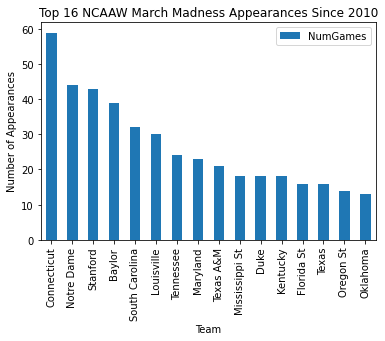

In [22]:
# use hist method to plot a histogram of the numgames column for each team
top_16_teams.plot(x = 'TeamName', y = 'NumGames', kind = 'bar')
plt.xlabel('Team')
plt.ylabel('Number of Appearances')
plt.title('Top 16 NCAAW March Madness Appearances Since 2010')
plt.show()

In [23]:
# Merging the two datasets, sorting by the season and the day number of the game so that
# the games line up in order
merged_df = pd.concat([season_df, tourney_df])

# sort the merged dataframe by "col_name" in ascending order
sorted_df = merged_df.sort_values(['Season', 'DayNum'], ascending = [True, True])

# reset the index
games_df = sorted_df.reset_index(drop = True)
games_df

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2010,11,3103,63,3237,49,H,0,23,54,...,13,6,10,11,27,11,23,7,6,19
1,2010,11,3104,73,3399,68,N,0,26,62,...,21,14,27,14,26,7,20,4,2,27
2,2010,11,3110,71,3224,59,A,0,29,62,...,14,19,23,17,23,8,15,6,0,15
3,2010,11,3111,63,3267,58,A,0,27,52,...,26,16,25,22,22,15,11,14,5,14
4,2010,11,3119,74,3447,70,H,1,30,74,...,17,11,21,21,32,12,14,4,2,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70762,2023,113,3268,96,3234,68,H,0,34,71,...,38,11,15,18,19,14,24,5,3,14
70763,2023,113,3385,69,3163,64,A,0,23,63,...,21,12,15,11,25,14,12,5,7,19
70764,2023,113,3416,57,3396,53,H,0,19,60,...,26,14,17,16,19,5,9,10,9,20
70765,2023,113,3437,67,3177,64,H,0,24,67,...,19,8,11,21,26,13,12,9,2,14


In [24]:
# Creating a new column for the difference in points for each game
games_df['ScoreGap'] = games_df['WScore'] - games_df['LScore']
games_df

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,ScoreGap
0,2010,11,3103,63,3237,49,H,0,23,54,...,6,10,11,27,11,23,7,6,19,14
1,2010,11,3104,73,3399,68,N,0,26,62,...,14,27,14,26,7,20,4,2,27,5
2,2010,11,3110,71,3224,59,A,0,29,62,...,19,23,17,23,8,15,6,0,15,12
3,2010,11,3111,63,3267,58,A,0,27,52,...,16,25,22,22,15,11,14,5,14,5
4,2010,11,3119,74,3447,70,H,1,30,74,...,11,21,21,32,12,14,4,2,14,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70762,2023,113,3268,96,3234,68,H,0,34,71,...,11,15,18,19,14,24,5,3,14,28
70763,2023,113,3385,69,3163,64,A,0,23,63,...,12,15,11,25,14,12,5,7,19,5
70764,2023,113,3416,57,3396,53,H,0,19,60,...,14,17,16,19,5,9,10,9,20,4
70765,2023,113,3437,67,3177,64,H,0,24,67,...,8,11,21,26,13,12,9,2,14,3


In [25]:
# Now pulling in the seed CSV which lists how each team was seeded going into the tourney for that year
# Also taken from kaggle
seeds_df = pd.read_csv('/Users/aheinke/Documents/Flatiron/NYC-DS-010923/Phase_3/Phase3_Proj/PROJ_CSVs/WNCAATourneySeeds.csv')
seeds_df

,Season,Seed,TeamID
0,1998,W01,3330
1,1998,W02,3163
2,1998,W03,3112
3,1998,W04,3301
4,1998,W05,3272
...,...,...,...
1535,2022,Z12,3125
1536,2022,Z13,3138
1537,2022,Z14,3110
1538,2022,Z15,3218


In [26]:
# Converting the seed data to numerical values so that they can be used in our model
seeds_df['SeedNum'] = seeds_df['Seed'].str.extract('(\d+)').astype(int)
seeds_df

,Season,Seed,TeamID,SeedNum
0,1998,W01,3330,1
1,1998,W02,3163,2
2,1998,W03,3112,3
3,1998,W04,3301,4
4,1998,W05,3272,5
...,...,...,...,...
1535,2022,Z12,3125,12
1536,2022,Z13,3138,13
1537,2022,Z14,3110,14
1538,2022,Z15,3218,15


In [27]:
# Making a dictionary from the dataset so that we can pull every team's "seed" (if they had one) 
# into our initial dataset. We're refencing both the Season and TeamID
team_season_seed_dict = dict(zip(zip(seeds_df['TeamID'], seeds_df['Season']), seeds_df['SeedNum']))
team_season_seed_dict

{(3330, 1998): 1,
 (3163, 1998): 2,
 (3112, 1998): 3,
 (3301, 1998): 4,
 (3272, 1998): 5,
 (3438, 1998): 6,
 (3208, 1998): 7,
 (3307, 1998): 8,
 (3304, 1998): 9,
 (3203, 1998): 10,
 (3374, 1998): 11,
 (3464, 1998): 12,
 (3263, 1998): 13,
 (3365, 1998): 14,
 (3193, 1998): 15,
 (3384, 1998): 16,
 (3403, 1998): 1,
 (3104, 1998): 2,
 (3256, 1998): 3,
 (3345, 1998): 4,
 (3179, 1998): 5,
 (3155, 1998): 6,
 (3417, 1998): 7,
 (3283, 1998): 8,
 (3323, 1998): 9,
 (3276, 1998): 10,
 (3274, 1998): 11,
 (3161, 1998): 12,
 (3449, 1998): 13,
 (3221, 1998): 14,
 (3422, 1998): 15,
 (3212, 1998): 16,
 (3397, 1998): 1,
 (3314, 1998): 2,
 (3228, 1998): 3,
 (3235, 1998): 4,
 (3353, 1998): 5,
 (3435, 1998): 6,
 (3198, 1998): 7,
 (3443, 1998): 8,
 (3372, 1998): 9,
 (3266, 1998): 10,
 (3364, 1998): 11,
 (3332, 1998): 12,
 (3245, 1998): 13,
 (3453, 1998): 14,
 (3224, 1998): 15,
 (3251, 1998): 16,
 (3390, 1998): 1,
 (3181, 1998): 2,
 (3196, 1998): 3,
 (3234, 1998): 4,
 (3242, 1998): 5,
 (3458, 1998): 6,
 (3428,

In [28]:
# Using our dictionary to pull in the seed information based on both the 'WTeamID' and 'LTeamID'
# We'll be making new columns for each
# There are going to be some N/A's when we add this into our dataset, as there are 350+ teams and only 64 are selected 
# So replacing the N/A's with a zero in keeping our data for this column numerical
games_df['WSeed'] = games_df.apply(lambda row: team_season_seed_dict.get((row['WTeamID'], row['Season']),\
                                                                           0), axis = 1)

In [29]:
games_df['LSeed'] = games_df.apply(lambda row: team_season_seed_dict.get((row['LTeamID'], row['Season']),\
                                                                           0), axis = 1)

In [30]:
games_df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,ScoreGap,WSeed,LSeed
0,2010,11,3103,63,3237,49,H,0,23,54,...,11,27,11,23,7,6,19,14,0,0
1,2010,11,3104,73,3399,68,N,0,26,62,...,14,26,7,20,4,2,27,5,0,0
2,2010,11,3110,71,3224,59,A,0,29,62,...,17,23,8,15,6,0,15,12,0,0
3,2010,11,3111,63,3267,58,A,0,27,52,...,22,22,15,11,14,5,14,5,0,0
4,2010,11,3119,74,3447,70,H,1,30,74,...,21,32,12,14,4,2,14,4,0,0


In [31]:
total_season_wins = games_df.groupby(['Season', 'WTeamID']).count()
total_season_wins = total_season_wins.reset_index()[['Season', 'WTeamID', 'DayNum']].rename(columns = {'DayNum':\
                                                                                    'NumWins', 'WTeamID': 'TeamID'})
total_season_wins.head()

,Season,TeamID,NumWins
0,2010,3102,1
1,2010,3103,17
2,2010,3104,11
3,2010,3105,14
4,2010,3106,12


In [32]:
total_season_losses = games_df.groupby(['Season', 'LTeamID']).count()
total_season_losses = total_season_losses.reset_index()[['Season', 'LTeamID', 'DayNum']].rename(columns = {'DayNum':\
                                                                                    'NumLosses', 'LTeamID': 'TeamID'})
total_season_losses.head()

,Season,TeamID,NumLosses
0,2010,3102,27
1,2010,3103,13
2,2010,3104,18
3,2010,3105,13
4,2010,3106,17


In [33]:
win_margin = games_df.groupby(['Season', 'WTeamID']).mean().reset_index()
win_margin = win_margin[['Season', 'WTeamID', 'ScoreGap']].rename(columns = {'ScoreGap': 'WinGap', 'WTeamID': 'TeamID'})
win_margin.head()

,Season,TeamID,WinGap
0,2010,3102,20.000000
1,2010,3103,13.176471
2,2010,3104,15.363636
3,2010,3105,7.357143
4,2010,3106,8.500000


In [34]:
loss_margin = games_df.groupby(['Season', 'LTeamID']).mean().reset_index()
loss_margin = loss_margin[['Season', 'LTeamID', 'ScoreGap']].rename(columns = {'ScoreGap': 'LossGap', 'LTeamID': 'TeamID'})
loss_margin.head()

,Season,TeamID,LossGap
0,2010,3102,21.444444
1,2010,3103,11.230769
2,2010,3104,14.000000
3,2010,3105,16.153846
4,2010,3106,9.882353


In [35]:
df_features_season_w = games_df.groupby(['Season', 'WTeamID']).count().reset_index()[['Season',\
                                                'WTeamID']].rename(columns = {'WTeamID': 'TeamID'})
df_features_season_l = games_df.groupby(['Season', 'LTeamID']).count().reset_index()[['Season',\
                                                'LTeamID']].rename(columns = {'LTeamID': 'TeamID'})

In [36]:
df_features_season = pd.concat([df_features_season_w, df_features_season_l],\
                               0).drop_duplicates().sort_values(['Season', 'TeamID']).reset_index(drop = True)

In [37]:
df_features_season = df_features_season.merge(total_season_wins, on = ['Season', 'TeamID'], how = 'left')
df_features_season = df_features_season.merge(total_season_losses, on = ['Season', 'TeamID'], how = 'left')
df_features_season = df_features_season.merge(win_margin, on = ['Season', 'TeamID'], how = 'left')
df_features_season = df_features_season.merge(loss_margin, on = ['Season', 'TeamID'], how = 'left')

In [38]:
df_features_season.fillna(0, inplace = True)

In [39]:
df_features_season['WinRatio'] = 100 * (df_features_season['NumWins'] / (df_features_season['NumWins'] + \
                                                                         df_features_season['NumLosses']))
df_features_season['GapAvg'] = (
    (df_features_season['NumWins'] * df_features_season['WinGap'] - 
    df_features_season['NumLosses'] * df_features_season['LossGap'])
    / (df_features_season['NumWins'] + df_features_season['NumLosses'])
)

In [40]:
df_features_season

,Season,TeamID,NumWins,NumLosses,WinGap,LossGap,WinRatio,GapAvg
0,2010,3102,1.0,27.0,20.000000,21.444444,3.571429,-19.964286
1,2010,3103,17.0,13.0,13.176471,11.230769,56.666667,2.600000
2,2010,3104,11.0,18.0,15.363636,14.000000,37.931034,-2.862069
3,2010,3105,14.0,13.0,7.357143,16.153846,51.851852,-3.962963
4,2010,3106,12.0,17.0,8.500000,9.882353,41.379310,-2.275862
...,...,...,...,...,...,...,...,...
4875,2023,3473,1.0,22.0,9.000000,19.318182,4.347826,-18.086957
4876,2023,3474,5.0,18.0,10.200000,19.888889,21.739130,-13.347826
4877,2023,3475,8.0,16.0,13.875000,11.625000,33.333333,-3.125000
4878,2023,3476,7.0,19.0,10.571429,13.368421,26.923077,-6.923077


In [41]:
games_features_df = pd.merge(
    games_df,
    df_features_season,
    how = 'left',
    left_on = ['Season', 'WTeamID'],
    right_on = ['Season', 'TeamID']
).rename(columns = {
    'NumWins': 'NumWinsW',
    'NumLosses': 'NumLossesW',
    'WinGap': 'WinGapW',
    'LossGap': 'LossGapW',
    'WinRatio': 'WinRatioW',
    'GapAvg': 'GapAvgW',
}).drop(columns = 'TeamID', axis = 1)

In [42]:
games_features_df = pd.merge(
    games_features_df,
    df_features_season,
    how = 'left',
    left_on = ['Season', 'LTeamID'],
    right_on = ['Season', 'TeamID']
).rename(columns = {
    'NumWins': 'NumWinsL',
    'NumLosses': 'NumLossesL',
    'WinGap': 'WinGapL',
    'LossGap': 'LossGapL',
    'WinRatio': 'WinRatioL',
    'GapAvg': 'GapAvgL',
}).drop(columns = 'TeamID', axis = 1)

In [43]:
games_features_df

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,WinGapW,LossGapW,WinRatioW,GapAvgW,NumWinsL,NumLossesL,WinGapL,LossGapL,WinRatioL,GapAvgL
0,2010,11,3103,63,3237,49,H,0,23,54,...,13.176471,11.230769,56.666667,2.600000,2.0,26.0,15.000000,21.230769,7.142857,-18.642857
1,2010,11,3104,73,3399,68,N,0,26,62,...,15.363636,14.000000,37.931034,-2.862069,13.0,16.0,14.692308,16.312500,44.827586,-2.413793
2,2010,11,3110,71,3224,59,A,0,29,62,...,16.230769,10.500000,61.904762,6.047619,15.0,14.0,7.200000,13.214286,51.724138,-2.655172
3,2010,11,3111,63,3267,58,A,0,27,52,...,11.263158,11.166667,61.290323,2.580645,13.0,16.0,7.846154,11.375000,44.827586,-2.758621
4,2010,11,3119,74,3447,70,H,1,30,74,...,9.500000,14.437500,33.333333,-6.458333,9.0,21.0,8.333333,13.190476,30.000000,-6.733333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70762,2023,113,3268,96,3234,68,H,0,34,71,...,16.478261,15.600000,82.142857,10.750000,22.0,6.0,24.090909,10.333333,78.571429,16.714286
70763,2023,113,3385,69,3163,64,A,0,23,63,...,15.050000,17.000000,74.074074,6.740741,24.0,5.0,22.375000,7.400000,82.758621,17.241379
70764,2023,113,3416,57,3396,53,H,0,19,60,...,14.916667,18.384615,48.000000,-2.400000,10.0,16.0,11.100000,11.312500,38.461538,-2.692308
70765,2023,113,3437,67,3177,64,H,0,24,67,...,18.041667,10.400000,82.758621,13.137931,15.0,14.0,21.000000,11.642857,51.724138,5.241379


In [44]:
# true shooting percentage
games_features_df['1SP'] = 100 * ((0.5 * games_features_df['WScore']) / (games_features_df['WFGA'] + (0.475 * \
                                                                                games_features_df['WFTA'])))
games_features_df['2SP'] = 100 * ((0.5 * games_features_df['LScore']) / (games_features_df['LFGA'] + (0.475 * \
                                                                                games_features_df['LFTA'])))

In [45]:
games_features_df

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,WinRatioW,GapAvgW,NumWinsL,NumLossesL,WinGapL,LossGapL,WinRatioL,GapAvgL,1SP,2SP
0,2010,11,3103,63,3237,49,H,0,23,54,...,56.666667,2.600000,2.0,26.0,15.000000,21.230769,7.142857,-18.642857,49.980167,41.702128
1,2010,11,3104,73,3399,68,N,0,26,62,...,37.931034,-2.862069,13.0,16.0,14.692308,16.312500,44.827586,-2.413793,48.472776,44.840092
2,2010,11,3110,71,3224,59,A,0,29,62,...,61.904762,6.047619,15.0,14.0,7.200000,13.214286,51.724138,-2.655172,52.437223,42.800145
3,2010,11,3111,63,3267,58,A,0,27,52,...,61.290323,2.580645,13.0,16.0,7.846154,11.375000,44.827586,-2.758621,55.975122,33.770015
4,2010,11,3119,74,3447,70,H,1,30,74,...,33.333333,-6.458333,9.0,21.0,8.333333,13.190476,30.000000,-6.733333,46.702430,41.679071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70762,2023,113,3268,96,3234,68,H,0,34,71,...,82.142857,10.750000,22.0,6.0,24.090909,10.333333,78.571429,16.714286,61.440000,46.495726
70763,2023,113,3385,69,3163,64,A,0,23,63,...,74.074074,6.740741,24.0,5.0,22.375000,7.400000,82.758621,17.241379,48.218029,46.292948
70764,2023,113,3416,57,3396,53,H,0,19,60,...,48.000000,-2.400000,10.0,16.0,11.100000,11.312500,38.461538,-2.692308,39.134912,33.941723
70765,2023,113,3437,67,3177,64,H,0,24,67,...,82.758621,13.137931,15.0,14.0,21.000000,11.642857,51.724138,5.241379,45.193929,38.917604


In [46]:
# Grouping by Team and Season to obtain the mean for our necessary stats
group = games_features_df.groupby(['Season','WTeamID'])
games_features = group.mean()
games_features

DayNum     WScore      LTeamID     LScore     NumOT  \
Season WTeamID                                                           
2010   3102     32.000000  68.000000  3152.000000  48.000000  0.000000   
       3103     74.941176  66.352941  3247.647059  53.176471  0.058824   
       3104     57.181818  72.818182  3267.000000  57.454545  0.000000   
       3105     87.000000  66.428571  3217.500000  59.071429  0.000000   
       3106     88.666667  59.833333  3230.666667  51.333333  0.083333   
...                   ...        ...          ...        ...       ...   
2023   3473     96.000000  84.000000  3404.000000  75.000000  0.000000   
       3474     62.200000  68.600000  3334.400000  58.400000  0.000000   
       3475     63.000000  71.750000  3359.625000  57.875000  0.000000   
       3476     64.714286  65.571429  3227.285714  55.000000  0.000000   
       3477     79.090909  73.454545  3271.090909  62.454545  0.000000   

                     WFGM       WFGA      WFGM3      WFGA3       WFTM  ...  \
Season WTeamID                                                         ...   
2010   3102     23.000000  51.000000   6.000000  14.000000  16.000000  ...   
       3103     23.941176  56.000000   4.352941  12.235294  14.117647  ...   
       3104     28.000000  59.545455   4.818182  13.636364  12.000000  ...   
       3105     21.785714  47.571429   3.142857   8.357143  19.714286  ...   
       3106     19.583333  49.833333   2.250000   7.000000  18.416667  ...   
...                   ...        ...        ...        ...        ...  ...   
2023   3473     29.000000  47.000000  14.000000  26.000000  12.000000  ...   
       3474     23.800000  59.000000   6.800000  20.200000  14.200000  ...   
       3475     24.875000  59.375000   5.375000  16.625000  16.625000  ...   
       3476     24.285714  56.142857   7.000000  19.000000  10.000000  ...   
       3477     26.818182  59.090909   4.272727  14.545455  15.545455  ...   

                WinRatioW    GapAvgW   NumWinsL  NumLossesL    WinGapL  \
Season WTeamID                                                           
2010   3102      3.571429 -19.964286   9.000000   18.000000  14.000000   
       3103     56.666667   2.600000  10.000000   19.176471  11.981285   
       3104     37.931034  -2.862069  11.000000   17.727273  12.561448   
       3105     51.851852  -3.962963  10.500000   17.500000  10.469473   
       3106     41.379310  -2.275862   9.750000   18.583333  10.527159   
...                   ...        ...        ...         ...        ...   
2023   3473      4.347826 -18.086957  11.000000   16.000000  14.181818   
       3474     21.739130 -13.347826   7.000000   17.800000   8.768571   
       3475     33.333333  -3.125000   6.500000   18.250000  10.018750   
       3476     26.923077  -6.923077   5.571429   19.285714   9.977381   
       3477     42.307692  -5.000000   7.363636   16.272727  10.243934   

                 LossGapL  WinRatioL    GapAvgL        1SP        2SP  
Season WTeamID                                                         
2010   3102     14.500000  33.333333  -5.000000  55.760558  38.277512  
       3103     14.173460  34.613575  -5.626469  51.040934  41.037520  
       3104     15.092754  38.134376  -4.569409  53.028467  42.252070  
       3105     15.154323  37.237395  -5.490715  55.354892  43.509581  
       3106     15.717463  34.290277  -6.754353  47.706953  40.726426  
...                   ...        ...        ...        ...        ...  
2023   3473     11.625000  40.740741  -1.111111  76.923077  47.483381  
       3474     19.879650  28.281159 -12.364498  50.234025  48.307636  
       3475     18.460807  26.100845 -11.348105  51.485078  44.592368  
       3476     17.542286  22.366300 -11.481300  51.840605  43.478205  
       3477     17.159796  31.456381  -8.477458  53.165958  48.006340  

[4860 rows x 48 columns]

In [47]:
games_features_df2 = games_features.reset_index()

In [48]:
games_features_df2 = games_features_df2[['Season', 'WTeamID', 'WScore', 'LScore', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl',\
                                        'WBlk', 'WPF', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 'ScoreGap']]

In [49]:
games_features_df2

,Season,WTeamID,WScore,LScore,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,ScoreGap
0,2010,3102,68.000000,48.000000,11.000000,29.000000,13.000000,14.000000,9.000000,1.000000,10.000000,14.000000,19.000000,13.000000,18.000000,7.000000,5.000000,17.000000,20.000000
1,2010,3103,66.352941,53.176471,14.176471,25.764706,14.235294,16.882353,8.705882,2.705882,16.058824,14.823529,20.764706,9.764706,19.058824,8.882353,3.705882,18.176471,13.176471
2,2010,3104,72.818182,57.454545,14.363636,28.000000,17.181818,20.545455,8.454545,3.000000,18.454545,14.818182,21.454545,10.818182,22.181818,8.636364,2.818182,18.181818,15.363636
3,2010,3105,66.428571,59.071429,11.285714,25.571429,11.285714,25.714286,8.928571,5.642857,18.714286,15.357143,18.428571,12.571429,22.142857,12.071429,3.285714,22.428571,7.357143
4,2010,3106,59.833333,51.333333,14.916667,25.583333,12.166667,19.250000,7.500000,5.333333,21.750000,14.166667,19.750000,7.416667,17.833333,8.000000,3.416667,22.583333,8.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4855,2023,3473,84.000000,75.000000,5.000000,25.000000,26.000000,25.000000,8.000000,6.000000,15.000000,13.000000,12.000000,12.000000,13.000000,17.000000,1.000000,18.000000,9.000000
4856,2023,3474,68.600000,58.400000,10.000000,22.400000,9.600000,13.000000,8.600000,2.000000,19.600000,7.200000,23.000000,8.200000,17.600000,5.800000,2.800000,17.600000,10.200000
4857,2023,3475,71.750000,57.875000,11.000000,27.000000,14.750000,18.000000,8.375000,3.750000,18.500000,7.875000,21.250000,9.250000,19.000000,8.625000,3.375000,21.125000,13.875000
4858,2023,3476,65.571429,55.000000,8.428571,24.857143,15.571429,14.000000,4.857143,2.714286,14.714286,7.714286,20.571429,7.571429,13.285714,6.000000,3.000000,16.714286,10.571429


In [50]:
# merging all
merged_df = pd.merge(games_features_df, games_features_df2, how = 'left', on = ['Season', 'WTeamID', 'WScore', \
                                'LScore', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF',\
                    'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 'ScoreGap'])
merged_df

/Users/aheinke/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/reshape/merge.py:1123: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,WinRatioW,GapAvgW,NumWinsL,NumLossesL,WinGapL,LossGapL,WinRatioL,GapAvgL,1SP,2SP
0,2010,11,3103,63,3237,49,H,0,23,54,...,56.666667,2.600000,2.0,26.0,15.000000,21.230769,7.142857,-18.642857,49.980167,41.702128
1,2010,11,3104,73,3399,68,N,0,26,62,...,37.931034,-2.862069,13.0,16.0,14.692308,16.312500,44.827586,-2.413793,48.472776,44.840092
2,2010,11,3110,71,3224,59,A,0,29,62,...,61.904762,6.047619,15.0,14.0,7.200000,13.214286,51.724138,-2.655172,52.437223,42.800145
3,2010,11,3111,63,3267,58,A,0,27,52,...,61.290323,2.580645,13.0,16.0,7.846154,11.375000,44.827586,-2.758621,55.975122,33.770015
4,2010,11,3119,74,3447,70,H,1,30,74,...,33.333333,-6.458333,9.0,21.0,8.333333,13.190476,30.000000,-6.733333,46.702430,41.679071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70762,2023,113,3268,96,3234,68,H,0,34,71,...,82.142857,10.750000,22.0,6.0,24.090909,10.333333,78.571429,16.714286,61.440000,46.495726
70763,2023,113,3385,69,3163,64,A,0,23,63,...,74.074074,6.740741,24.0,5.0,22.375000,7.400000,82.758621,17.241379,48.218029,46.292948
70764,2023,113,3416,57,3396,53,H,0,19,60,...,48.000000,-2.400000,10.0,16.0,11.100000,11.312500,38.461538,-2.692308,39.134912,33.941723
70765,2023,113,3437,67,3177,64,H,0,24,67,...,82.758621,13.137931,15.0,14.0,21.000000,11.642857,51.724138,5.241379,45.193929,38.917604


In [51]:
# Creating a GameID column for reference once we slpit our rows below
merged_df['GameID'] = merged_df.index
merged_df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,GapAvgW,NumWinsL,NumLossesL,WinGapL,LossGapL,WinRatioL,GapAvgL,1SP,2SP,GameID
0,2010,11,3103,63,3237,49,H,0,23,54,...,2.600000,2.0,26.0,15.000000,21.230769,7.142857,-18.642857,49.980167,41.702128,0
1,2010,11,3104,73,3399,68,N,0,26,62,...,-2.862069,13.0,16.0,14.692308,16.312500,44.827586,-2.413793,48.472776,44.840092,1
2,2010,11,3110,71,3224,59,A,0,29,62,...,6.047619,15.0,14.0,7.200000,13.214286,51.724138,-2.655172,52.437223,42.800145,2
3,2010,11,3111,63,3267,58,A,0,27,52,...,2.580645,13.0,16.0,7.846154,11.375000,44.827586,-2.758621,55.975122,33.770015,3
4,2010,11,3119,74,3447,70,H,1,30,74,...,-6.458333,9.0,21.0,8.333333,13.190476,30.000000,-6.733333,46.702430,41.679071,4


In [52]:
merged_df.columns.values.tolist()

['Season',
 'DayNum',
 'WTeamID',
 'WScore',
 'LTeamID',
 'LScore',
 'WLoc',
 'NumOT',
 'WFGM',
 'WFGA',
 'WFGM3',
 'WFGA3',
 'WFTM',
 'WFTA',
 'WOR',
 'WDR',
 'WAst',
 'WTO',
 'WStl',
 'WBlk',
 'WPF',
 'LFGM',
 'LFGA',
 'LFGM3',
 'LFGA3',
 'LFTM',
 'LFTA',
 'LOR',
 'LDR',
 'LAst',
 'LTO',
 'LStl',
 'LBlk',
 'LPF',
 'ScoreGap',
 'WSeed',
 'LSeed',
 'NumWinsW',
 'NumLossesW',
 'WinGapW',
 'LossGapW',
 'WinRatioW',
 'GapAvgW',
 'NumWinsL',
 'NumLossesL',
 'WinGapL',
 'LossGapL',
 'WinRatioL',
 'GapAvgL',
 '1SP',
 '2SP',
 'GameID']

In [53]:
# Creating a winners dataframe with all of the necessary columns which will be concatenated with
# a similar losers column to create our final dataframe
# (excluding the 'WFGM' column, as this is already accounted for by the 'WScore')
cols_to_keep = ['GameID', 'Season', 'DayNum', 'WTeamID', 'WSeed', 'WScore', 'LTeamID', 'LSeed', 'LScore', 'WLoc',\
                'NumOT', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', '1SP', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl',\
                'WBlk', 'WPF', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', '2SP', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl',\
                'LBlk', 'LPF','ScoreGap', 'NumWinsW', 'NumLossesW', 'WinGapW', 'LossGapW', 'WinRatioW', 'GapAvgW',\
                'NumWinsL', 'NumLossesL', 'WinGapL', 'LossGapL', 'WinRatioL', 'GapAvgL']
winners_df = merged_df[cols_to_keep]
winners_df

,GameID,Season,DayNum,WTeamID,WSeed,WScore,LTeamID,LSeed,LScore,WLoc,...,WinGapW,LossGapW,WinRatioW,GapAvgW,NumWinsL,NumLossesL,WinGapL,LossGapL,WinRatioL,GapAvgL
0,0,2010,11,3103,0,63,3237,0,49,H,...,13.176471,11.230769,56.666667,2.600000,2.0,26.0,15.000000,21.230769,7.142857,-18.642857
1,1,2010,11,3104,0,73,3399,0,68,N,...,15.363636,14.000000,37.931034,-2.862069,13.0,16.0,14.692308,16.312500,44.827586,-2.413793
2,2,2010,11,3110,0,71,3224,0,59,A,...,16.230769,10.500000,61.904762,6.047619,15.0,14.0,7.200000,13.214286,51.724138,-2.655172
3,3,2010,11,3111,0,63,3267,0,58,A,...,11.263158,11.166667,61.290323,2.580645,13.0,16.0,7.846154,11.375000,44.827586,-2.758621
4,4,2010,11,3119,0,74,3447,0,70,H,...,9.500000,14.437500,33.333333,-6.458333,9.0,21.0,8.333333,13.190476,30.000000,-6.733333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70762,70762,2023,113,3268,0,96,3234,0,68,H,...,16.478261,15.600000,82.142857,10.750000,22.0,6.0,24.090909,10.333333,78.571429,16.714286
70763,70763,2023,113,3385,0,69,3163,0,64,A,...,15.050000,17.000000,74.074074,6.740741,24.0,5.0,22.375000,7.400000,82.758621,17.241379
70764,70764,2023,113,3416,0,57,3396,0,53,H,...,14.916667,18.384615,48.000000,-2.400000,10.0,16.0,11.100000,11.312500,38.461538,-2.692308
70765,70765,2023,113,3437,0,67,3177,0,64,H,...,18.041667,10.400000,82.758621,13.137931,15.0,14.0,21.000000,11.642857,51.724138,5.241379


In [54]:
# Renaming each of the columns so that they aren't tied to a winning or losing team
dict = {'WTeamID': '1Team', 'WSeed': '1Seed', 'WScore': '1Score', 'LTeamID': '2Team', 'LSeed': '2Seed',\
        'LScore': '2Score', 'WLoc': 'Loc', 'WFGA': '1FGA', 'WFGM3': '1FGM3','WFGA3': '1FGA3', 'WFTM': '1FTM',\
        'WFTA': '1FTA', 'WOR': '1OR', 'WDR': '1DR', 'WAst': '1Ast', 'WTO': '1TO', 'WStl': '1Stl', 'WBlk': '1Blk',\
        'WPF': '1PF', 'LFGA': '2FGA', 'LFGM3': '2FGM3', 'LFGA3': '2FGA3', 'LFTM': '2FTM', 'LFTA': '2FTA',\
        'LOR': '2OR', 'LDR': '2DR', 'LAst': '2Ast', 'LTO': '2TO', 'LStl': '2Stl', 'LBlk': '2Blk', 'LPF': '2PF',\
        'NumWinsW': '1NumWins', 'NumLossesW': '1NumLosses', 'WinGapW': '1WinGap', 'LossGapW': '1LossGap',\
        'WinRatioW': '1WinRatio', 'GapAvgW': '1GapAvg', 'NumWinsL': '2NumWins', 'NumLossesL': '2NumLosses',\
        'WinGapL': '2WinGap', 'LossGapL': '2LossGap', 'WinRatioL': '2WinRatio', 'GapAvgL': '2GapAvg'}

In [55]:
winners_df.rename(columns = dict, inplace = True)
winners_df

/Users/aheinke/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,GameID,Season,DayNum,1Team,1Seed,1Score,2Team,2Seed,2Score,Loc,...,1WinGap,1LossGap,1WinRatio,1GapAvg,2NumWins,2NumLosses,2WinGap,2LossGap,2WinRatio,2GapAvg
0,0,2010,11,3103,0,63,3237,0,49,H,...,13.176471,11.230769,56.666667,2.600000,2.0,26.0,15.000000,21.230769,7.142857,-18.642857
1,1,2010,11,3104,0,73,3399,0,68,N,...,15.363636,14.000000,37.931034,-2.862069,13.0,16.0,14.692308,16.312500,44.827586,-2.413793
2,2,2010,11,3110,0,71,3224,0,59,A,...,16.230769,10.500000,61.904762,6.047619,15.0,14.0,7.200000,13.214286,51.724138,-2.655172
3,3,2010,11,3111,0,63,3267,0,58,A,...,11.263158,11.166667,61.290323,2.580645,13.0,16.0,7.846154,11.375000,44.827586,-2.758621
4,4,2010,11,3119,0,74,3447,0,70,H,...,9.500000,14.437500,33.333333,-6.458333,9.0,21.0,8.333333,13.190476,30.000000,-6.733333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70762,70762,2023,113,3268,0,96,3234,0,68,H,...,16.478261,15.600000,82.142857,10.750000,22.0,6.0,24.090909,10.333333,78.571429,16.714286
70763,70763,2023,113,3385,0,69,3163,0,64,A,...,15.050000,17.000000,74.074074,6.740741,24.0,5.0,22.375000,7.400000,82.758621,17.241379
70764,70764,2023,113,3416,0,57,3396,0,53,H,...,14.916667,18.384615,48.000000,-2.400000,10.0,16.0,11.100000,11.312500,38.461538,-2.692308
70765,70765,2023,113,3437,0,67,3177,0,64,H,...,18.041667,10.400000,82.758621,13.137931,15.0,14.0,21.000000,11.642857,51.724138,5.241379


In [56]:
# Creating the losers dataframe with all of the necessary columns 
# (excluding the 'LFGM' column, as this is already accounted for by the 'LScore')
cols_to_keep = ['GameID', 'Season', 'DayNum', 'LTeamID', 'LSeed', 'LScore', 'WTeamID', 'WSeed', 'WScore','WLoc',\
                'NumOT', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', '2SP', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl',\
                'LBlk', 'LPF', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', '1SP', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl',\
                'WBlk', 'WPF', 'ScoreGap', 'NumWinsL', 'NumLossesL', 'WinGapL', 'LossGapL', 'WinRatioL', 'GapAvgL',\
                'NumWinsW', 'NumLossesW', 'WinGapW', 'LossGapW', 'WinRatioW', 'GapAvgW']
losers_df = merged_df[cols_to_keep]
losers_df

,GameID,Season,DayNum,LTeamID,LSeed,LScore,WTeamID,WSeed,WScore,WLoc,...,WinGapL,LossGapL,WinRatioL,GapAvgL,NumWinsW,NumLossesW,WinGapW,LossGapW,WinRatioW,GapAvgW
0,0,2010,11,3237,0,49,3103,0,63,H,...,15.000000,21.230769,7.142857,-18.642857,17.0,13.0,13.176471,11.230769,56.666667,2.600000
1,1,2010,11,3399,0,68,3104,0,73,N,...,14.692308,16.312500,44.827586,-2.413793,11.0,18.0,15.363636,14.000000,37.931034,-2.862069
2,2,2010,11,3224,0,59,3110,0,71,A,...,7.200000,13.214286,51.724138,-2.655172,13.0,8.0,16.230769,10.500000,61.904762,6.047619
3,3,2010,11,3267,0,58,3111,0,63,A,...,7.846154,11.375000,44.827586,-2.758621,19.0,12.0,11.263158,11.166667,61.290323,2.580645
4,4,2010,11,3447,0,70,3119,0,74,H,...,8.333333,13.190476,30.000000,-6.733333,8.0,16.0,9.500000,14.437500,33.333333,-6.458333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70762,70762,2023,113,3234,0,68,3268,0,96,H,...,24.090909,10.333333,78.571429,16.714286,23.0,5.0,16.478261,15.600000,82.142857,10.750000
70763,70763,2023,113,3163,0,64,3385,0,69,A,...,22.375000,7.400000,82.758621,17.241379,20.0,7.0,15.050000,17.000000,74.074074,6.740741
70764,70764,2023,113,3396,0,53,3416,0,57,H,...,11.100000,11.312500,38.461538,-2.692308,12.0,13.0,14.916667,18.384615,48.000000,-2.400000
70765,70765,2023,113,3177,0,64,3437,0,67,H,...,21.000000,11.642857,51.724138,5.241379,24.0,5.0,18.041667,10.400000,82.758621,13.137931


In [57]:
# Renaming each of the columns so that they aren't tied to a winning or losing team
dict = {'LTeamID': '1Team', 'LSeed': '1Seed', 'LScore': '1Score', 'WTeamID': '2Team', 'WSeed': '2Seed',\
        'WScore': '2Score', 'WLoc': 'Loc', 'LFGA': '1FGA', 'LFGM3': '1FGM3', 'LFGA3': '1FGA3', 'LFTM': '1FTM',\
        'LFTA': '1FTA', '2SP':'1SP', 'LOR': '1OR', 'LDR': '1DR', 'LAst': '1Ast', 'LTO': '1TO', 'LStl': '1Stl',\
        'LBlk': '1Blk', 'LPF': '1PF','WFGA': '2FGA', 'WFGM3': '2FGM3','WFGA3': '2FGA3', 'WFTM': '2FTM',\
        'WFTA': '2FTA', '1SP': '2SP', 'WOR': '2OR', 'WDR': '2DR', 'WAst': '2Ast', 'WTO': '2TO', 'WStl': '2Stl',\
        'WBlk': '2Blk', 'WPF': '2PF', 'NumWinsL': '1NumWins', 'NumLossesL': '1NumLosses', 'WinGapL': '1WinGap',\
        'LossGapL': '1LossGap', 'WinRatioL': '1WinRatio', 'GapAvgL': '1GapAvg', 'NumWinsW': '2NumWins',\
        'NumLossesW': '2NumLosses', 'WinGapW': '2WinGap', 'LossGapW': '2LossGap', 'WinRatioW': '2WinRatio',\
        'GapAvgW': '2GapAvg'}

In [58]:
losers_df.rename(columns = dict, inplace = True)
losers_df

/Users/aheinke/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,GameID,Season,DayNum,1Team,1Seed,1Score,2Team,2Seed,2Score,Loc,...,1WinGap,1LossGap,1WinRatio,1GapAvg,2NumWins,2NumLosses,2WinGap,2LossGap,2WinRatio,2GapAvg
0,0,2010,11,3237,0,49,3103,0,63,H,...,15.000000,21.230769,7.142857,-18.642857,17.0,13.0,13.176471,11.230769,56.666667,2.600000
1,1,2010,11,3399,0,68,3104,0,73,N,...,14.692308,16.312500,44.827586,-2.413793,11.0,18.0,15.363636,14.000000,37.931034,-2.862069
2,2,2010,11,3224,0,59,3110,0,71,A,...,7.200000,13.214286,51.724138,-2.655172,13.0,8.0,16.230769,10.500000,61.904762,6.047619
3,3,2010,11,3267,0,58,3111,0,63,A,...,7.846154,11.375000,44.827586,-2.758621,19.0,12.0,11.263158,11.166667,61.290323,2.580645
4,4,2010,11,3447,0,70,3119,0,74,H,...,8.333333,13.190476,30.000000,-6.733333,8.0,16.0,9.500000,14.437500,33.333333,-6.458333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70762,70762,2023,113,3234,0,68,3268,0,96,H,...,24.090909,10.333333,78.571429,16.714286,23.0,5.0,16.478261,15.600000,82.142857,10.750000
70763,70763,2023,113,3163,0,64,3385,0,69,A,...,22.375000,7.400000,82.758621,17.241379,20.0,7.0,15.050000,17.000000,74.074074,6.740741
70764,70764,2023,113,3396,0,53,3416,0,57,H,...,11.100000,11.312500,38.461538,-2.692308,12.0,13.0,14.916667,18.384615,48.000000,-2.400000
70765,70765,2023,113,3177,0,64,3437,0,67,H,...,21.000000,11.642857,51.724138,5.241379,24.0,5.0,18.041667,10.400000,82.758621,13.137931


In [59]:
# Merging our winning and losing dataframes into a new dataframe that we can run through our models!
merged_df2 = pd.concat([winners_df, losers_df])
ncaaw_df = merged_df2.sort_values(['GameID', 'Season'], ascending = [True, True])
ncaaw_df

,GameID,Season,DayNum,1Team,1Seed,1Score,2Team,2Seed,2Score,Loc,...,1WinGap,1LossGap,1WinRatio,1GapAvg,2NumWins,2NumLosses,2WinGap,2LossGap,2WinRatio,2GapAvg
0,0,2010,11,3103,0,63,3237,0,49,H,...,13.176471,11.230769,56.666667,2.600000,2.0,26.0,15.000000,21.230769,7.142857,-18.642857
0,0,2010,11,3237,0,49,3103,0,63,H,...,15.000000,21.230769,7.142857,-18.642857,17.0,13.0,13.176471,11.230769,56.666667,2.600000
1,1,2010,11,3104,0,73,3399,0,68,N,...,15.363636,14.000000,37.931034,-2.862069,13.0,16.0,14.692308,16.312500,44.827586,-2.413793
1,1,2010,11,3399,0,68,3104,0,73,N,...,14.692308,16.312500,44.827586,-2.413793,11.0,18.0,15.363636,14.000000,37.931034,-2.862069
2,2,2010,11,3110,0,71,3224,0,59,A,...,16.230769,10.500000,61.904762,6.047619,15.0,14.0,7.200000,13.214286,51.724138,-2.655172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70764,70764,2023,113,3396,0,53,3416,0,57,H,...,11.100000,11.312500,38.461538,-2.692308,12.0,13.0,14.916667,18.384615,48.000000,-2.400000
70765,70765,2023,113,3437,0,67,3177,0,64,H,...,18.041667,10.400000,82.758621,13.137931,15.0,14.0,21.000000,11.642857,51.724138,5.241379
70765,70765,2023,113,3177,0,64,3437,0,67,H,...,21.000000,11.642857,51.724138,5.241379,24.0,5.0,18.041667,10.400000,82.758621,13.137931
70766,70766,2023,113,3466,0,75,3146,0,42,A,...,15.777778,14.714286,39.130435,-2.782609,6.0,18.0,11.833333,20.666667,25.000000,-12.541667


In [60]:
ncaaw_df['Win1_Lose0'] = (ncaaw_df['1Score'] - ncaaw_df['2Score']).apply(lambda x:1 if x > 0 else 0)
ncaaw_df

,GameID,Season,DayNum,1Team,1Seed,1Score,2Team,2Seed,2Score,Loc,...,1LossGap,1WinRatio,1GapAvg,2NumWins,2NumLosses,2WinGap,2LossGap,2WinRatio,2GapAvg,Win1_Lose0
0,0,2010,11,3103,0,63,3237,0,49,H,...,11.230769,56.666667,2.600000,2.0,26.0,15.000000,21.230769,7.142857,-18.642857,1
0,0,2010,11,3237,0,49,3103,0,63,H,...,21.230769,7.142857,-18.642857,17.0,13.0,13.176471,11.230769,56.666667,2.600000,0
1,1,2010,11,3104,0,73,3399,0,68,N,...,14.000000,37.931034,-2.862069,13.0,16.0,14.692308,16.312500,44.827586,-2.413793,1
1,1,2010,11,3399,0,68,3104,0,73,N,...,16.312500,44.827586,-2.413793,11.0,18.0,15.363636,14.000000,37.931034,-2.862069,0
2,2,2010,11,3110,0,71,3224,0,59,A,...,10.500000,61.904762,6.047619,15.0,14.0,7.200000,13.214286,51.724138,-2.655172,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70764,70764,2023,113,3396,0,53,3416,0,57,H,...,11.312500,38.461538,-2.692308,12.0,13.0,14.916667,18.384615,48.000000,-2.400000,0
70765,70765,2023,113,3437,0,67,3177,0,64,H,...,10.400000,82.758621,13.137931,15.0,14.0,21.000000,11.642857,51.724138,5.241379,1
70765,70765,2023,113,3177,0,64,3437,0,67,H,...,11.642857,51.724138,5.241379,24.0,5.0,18.041667,10.400000,82.758621,13.137931,0
70766,70766,2023,113,3466,0,75,3146,0,42,A,...,14.714286,39.130435,-2.782609,6.0,18.0,11.833333,20.666667,25.000000,-12.541667,1


In [61]:
ncaaw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 141534 entries, 0 to 70766
Data columns (total 51 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   GameID      141534 non-null  int64  
 1   Season      141534 non-null  int64  
 2   DayNum      141534 non-null  int64  
 3   1Team       141534 non-null  int64  
 4   1Seed       141534 non-null  int64  
 5   1Score      141534 non-null  int64  
 6   2Team       141534 non-null  int64  
 7   2Seed       141534 non-null  int64  
 8   2Score      141534 non-null  int64  
 9   Loc         141534 non-null  object 
 10  NumOT       141534 non-null  int64  
 11  1FGA        141534 non-null  int64  
 12  1FGM3       141534 non-null  int64  
 13  1FGA3       141534 non-null  int64  
 14  1FTM        141534 non-null  int64  
 15  1FTA        141534 non-null  int64  
 16  1SP         141534 non-null  float64
 17  1OR         141534 non-null  int64  
 18  1DR         141534 non-null  int64  
 19  1As

In [62]:
wloc_map = {'H': 1, 'A': 2, 'N': 0}
ncaaw_df['Loc'] = ncaaw_df['Loc'].map(wloc_map)
ncaaw_df

,GameID,Season,DayNum,1Team,1Seed,1Score,2Team,2Seed,2Score,Loc,...,1LossGap,1WinRatio,1GapAvg,2NumWins,2NumLosses,2WinGap,2LossGap,2WinRatio,2GapAvg,Win1_Lose0
0,0,2010,11,3103,0,63,3237,0,49,1,...,11.230769,56.666667,2.600000,2.0,26.0,15.000000,21.230769,7.142857,-18.642857,1
0,0,2010,11,3237,0,49,3103,0,63,1,...,21.230769,7.142857,-18.642857,17.0,13.0,13.176471,11.230769,56.666667,2.600000,0
1,1,2010,11,3104,0,73,3399,0,68,0,...,14.000000,37.931034,-2.862069,13.0,16.0,14.692308,16.312500,44.827586,-2.413793,1
1,1,2010,11,3399,0,68,3104,0,73,0,...,16.312500,44.827586,-2.413793,11.0,18.0,15.363636,14.000000,37.931034,-2.862069,0
2,2,2010,11,3110,0,71,3224,0,59,2,...,10.500000,61.904762,6.047619,15.0,14.0,7.200000,13.214286,51.724138,-2.655172,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70764,70764,2023,113,3396,0,53,3416,0,57,1,...,11.312500,38.461538,-2.692308,12.0,13.0,14.916667,18.384615,48.000000,-2.400000,0
70765,70765,2023,113,3437,0,67,3177,0,64,1,...,10.400000,82.758621,13.137931,15.0,14.0,21.000000,11.642857,51.724138,5.241379,1
70765,70765,2023,113,3177,0,64,3437,0,67,1,...,11.642857,51.724138,5.241379,24.0,5.0,18.041667,10.400000,82.758621,13.137931,0
70766,70766,2023,113,3466,0,75,3146,0,42,2,...,14.714286,39.130435,-2.782609,6.0,18.0,11.833333,20.666667,25.000000,-12.541667,1


In [63]:
final_ncaaw_df = ncaaw_df.loc[ncaaw_df['Season'] < 2023]
final_ncaaw_df

,GameID,Season,DayNum,1Team,1Seed,1Score,2Team,2Seed,2Score,Loc,...,1LossGap,1WinRatio,1GapAvg,2NumWins,2NumLosses,2WinGap,2LossGap,2WinRatio,2GapAvg,Win1_Lose0
0,0,2010,11,3103,0,63,3237,0,49,1,...,11.230769,56.666667,2.600000,2.0,26.0,15.000000,21.230769,7.142857,-18.642857,1
0,0,2010,11,3237,0,49,3103,0,63,1,...,21.230769,7.142857,-18.642857,17.0,13.0,13.176471,11.230769,56.666667,2.600000,0
1,1,2010,11,3104,0,73,3399,0,68,0,...,14.000000,37.931034,-2.862069,13.0,16.0,14.692308,16.312500,44.827586,-2.413793,1
1,1,2010,11,3399,0,68,3104,0,73,0,...,16.312500,44.827586,-2.413793,11.0,18.0,15.363636,14.000000,37.931034,-2.862069,0
2,2,2010,11,3110,0,71,3224,0,59,2,...,10.500000,61.904762,6.047619,15.0,14.0,7.200000,13.214286,51.724138,-2.655172,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66166,66166,2022,151,3390,1,58,3163,2,63,0,...,4.250000,88.888889,16.694444,30.0,6.0,24.800000,10.833333,83.333333,18.861111,0
66167,66167,2022,151,3376,1,72,3257,1,59,0,...,1.500000,94.594595,20.216216,29.0,5.0,19.862069,5.400000,85.294118,16.147059,1
66167,66167,2022,151,3257,1,59,3376,1,72,0,...,5.400000,85.294118,16.147059,35.0,2.0,21.457143,1.500000,94.594595,20.216216,0
66168,66168,2022,153,3376,1,64,3163,2,49,0,...,1.500000,94.594595,20.216216,30.0,6.0,24.800000,10.833333,83.333333,18.861111,1


In [157]:
X = final_ncaaw_df.drop(['Win1_Lose0'], axis=1)
y = final_ncaaw_df['Win1_Lose0']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()

# Fit the scaler on the training data
scaler.fit(X_train)

# Transform the training and testing data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create an instance of XGBoost classifier
xgb_model = xgb.XGBClassifier()

# Fit the model on the scaled training data
xgb_model.fit(X_train_scaled, y_train)

# Predict on the scaled testing data
y_pred = xgb_model.predict(X_test_scaled)

In [158]:
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

0.9997733111682031
0.9997746563509352
0.9997746563509352
0.9997746563509352


The accuracy score of 0.9997733111682031 indicates the proportion of correctly predicted outcomes out of all predictions made by the model.

The precision score of 0.9997746563509352 indicates the proportion of true positive predictions out of all positive predictions made by the model.

The recall score of 0.9997746563509352 indicates the proportion of true positive predictions out of all actual positive outcomes in the test dataset.

The F1 score of 0.9997746563509352 is the harmonic mean of precision and recall and represents the balance between precision and recall of the model.

In summary, the XGBoost model achieved good performance with high accuracy, precision, recall, and F1 scores on the test dataset, indicating that it can effectively predict the outcomes of NCAA Women's Basketball games.

In [159]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13155
           1       1.00      1.00      1.00     13313

    accuracy                           1.00     26468
   macro avg       1.00      1.00      1.00     26468
weighted avg       1.00      1.00      1.00     26468



In [66]:
importances = xgb_model.feature_importances_

# Sort the features by their importance
sorted_indices = importances.argsort()[::-1]

# Print the feature importances in descending order
for feature in sorted_indices:
    print(f"Feature {feature}: {importances[feature]}")

Feature 8: 0.35184016823768616
Feature 5: 0.34644371271133423
Feature 37: 0.1627597212791443
Feature 29: 0.03880133852362633
Feature 16: 0.020776106044650078
Feature 42: 0.010639294981956482
Feature 48: 0.01003346312791109
Feature 27: 0.009295697323977947
Feature 35: 0.0057424986734986305
Feature 44: 0.004275600891560316
Feature 36: 0.0038559692911803722
Feature 28: 0.003738582134246826
Feature 14: 0.003634171560406685
Feature 9: 0.001846963888965547
Feature 49: 0.0018232720904052258
Feature 23: 0.0017942354315891862
Feature 15: 0.0014756402233615518
Feature 43: 0.0014120994601398706
Feature 41: 0.0013918434269726276
Feature 45: 0.001345300581306219
Feature 33: 0.001252629328519106
Feature 30: 0.0010680840350687504
Feature 18: 0.0009718486689962447
Feature 38: 0.0009589559049345553
Feature 39: 0.0009372970089316368
Feature 32: 0.0008110262569971383
Feature 34: 0.0007960909279063344
Feature 26: 0.000772581493947655
Feature 46: 0.0007397306035272777
Feature 3: 0.0007177161169238389
Featu

In [67]:
now_final_ncaaw_df = ncaaw_df[ncaaw_df['Season'] == 2023]
now_final_ncaaw_df

,GameID,Season,DayNum,1Team,1Seed,1Score,2Team,2Seed,2Score,Loc,...,1LossGap,1WinRatio,1GapAvg,2NumWins,2NumLosses,2WinGap,2LossGap,2WinRatio,2GapAvg,Win1_Lose0
66169,66169,2023,7,3102,0,67,3176,0,63,2,...,10.533333,40.000000,-2.000000,11.0,16.0,8.545455,15.437500,40.740741,-5.666667,1
66169,66169,2023,7,3176,0,63,3102,0,67,2,...,15.437500,40.740741,-5.666667,10.0,15.0,10.800000,10.533333,40.000000,-2.000000,0
66170,66170,2023,7,3104,0,98,3105,0,51,1,...,13.571429,74.074074,11.925926,13.0,12.0,9.384615,18.833333,52.000000,-4.160000,1
66170,66170,2023,7,3105,0,51,3104,0,98,1,...,18.833333,52.000000,-4.160000,20.0,7.0,20.850000,13.571429,74.074074,11.925926,0
66171,66171,2023,7,3113,0,69,3319,0,68,1,...,15.111111,28.000000,-8.200000,16.0,12.0,10.500000,13.000000,57.142857,0.428571,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70764,70764,2023,113,3396,0,53,3416,0,57,1,...,11.312500,38.461538,-2.692308,12.0,13.0,14.916667,18.384615,48.000000,-2.400000,0
70765,70765,2023,113,3437,0,67,3177,0,64,1,...,10.400000,82.758621,13.137931,15.0,14.0,21.000000,11.642857,51.724138,5.241379,1
70765,70765,2023,113,3177,0,64,3437,0,67,1,...,11.642857,51.724138,5.241379,24.0,5.0,18.041667,10.400000,82.758621,13.137931,0
70766,70766,2023,113,3466,0,75,3146,0,42,2,...,14.714286,39.130435,-2.782609,6.0,18.0,11.833333,20.666667,25.000000,-12.541667,1


In [68]:
import itertools
# Define the column you want to generate all possible pairs for
column_name = '1Team'

# Get all unique values in the column
unique_values = now_final_ncaaw_df[column_name].unique()

# Generate all possible pairs of values
value_pairs = list(itertools.combinations(unique_values, 2))

# Create a DataFrame to store the predictions for each pair
predictions_df = pd.DataFrame(columns = ['Team' + '_1', 'Team' + '_2', 'Prediction'])

# Loop through each pair of values and make a prediction
for pair in value_pairs:
    # Create a new DataFrame containing the features for the matchup you want to predict
    matchup_features = pd.DataFrame({
        'GameID': [0, 1, 2, 3],
        'Season': [0, 0, 0, 0],
        'DayNum': [0, 0, 0, 0],
        '1Team': [pair[0], pair[1], pair[0], pair[1]],
        '1Seed': [0, 0, 0, 0],
        '1Score': [0, 0, 0, 0],
        '2Team': [0, 0, 0, 0],
        '2Seed': [0, 0, 0, 0],
        '2Score': [0, 0, 0, 0],
        'Loc': [0, 0, 0, 0],
        'NumOT': [0, 0, 0, 0],
        '1FGA': [0, 0, 0, 0],
        '1FGM3': [0, 0, 0, 0],
        '1FGA3': [0, 0, 0, 0],
        '1FTM': [0, 0, 0, 0],
        '1FTA': [0, 0, 0, 0],
        '1SP': [0, 0, 0, 0],
        '1OR': [0, 0, 0, 0],
        '1DR': [0, 0, 0, 0],
        '1Ast': [0, 0, 0, 0],
        '1TO': [0, 0, 0, 0],
        '1Stl': [0, 0, 0, 0],
        '1Blk': [0, 0, 0, 0],
        '1PF': [0, 0, 0, 0],
        '2FGA': [0, 0, 0, 0],
        '2FGM3': [0, 0, 0, 0],
        '2FGA3': [0, 0, 0, 0],
        '2FTM': [0, 0, 0, 0],
        '2FTA': [0, 0, 0, 0],
        '2SP': [0, 0, 0, 0],
        '2OR': [0, 0, 0, 0],
        '2DR': [0, 0, 0, 0],
        '2Ast': [0, 0, 0, 0],
        '2TO': [0, 0, 0, 0],
        '2Stl': [0, 0, 0, 0],
        '2Blk': [0, 0, 0, 0],
        '2PF': [0, 0, 0, 0],
        'ScoreGap': [0, 0, 0, 0],
        '1NumWins': [0, 0, 0, 0],
        '1NumLosses': [0, 0, 0, 0],
        '1WinGap': [0, 0, 0, 0],
        '1LossGap': [0, 0, 0, 0],
        '1WinRatio': [0, 0, 0, 0],
        '1GapAvg': [0, 0, 0, 0],
        '2NumWins': [0, 0, 0, 0],
        '2NumLosses': [0, 0, 0, 0],
        '2WinGap': [0, 0, 0, 0],
        '2LossGap': [0, 0, 0, 0],
        '2WinRatio': [0, 0, 0, 0],
        '2GapAvg': [0, 0, 0, 0],
    })

    # Replace prediction = xgb_model.predict(matchup_features) with the following line
    prediction = xgb_model.predict_proba(matchup_features)

    # Extract the probability of the positive class (i.e., team 1 wins)
    proba_team_1_wins = prediction[0, 1]

    # Append the prediction to the DataFrame
    predictions_df = predictions_df.append({
        'Team' + '_1': pair[0],
        'Team' + '_2': pair[1],
        'Prediction': proba_team_1_wins
    }, ignore_index = True)

# Print the predictions DataFrame
predictions_df

,Team_1,Team_2,Prediction
0,3102.0,3176.0,0.010688
1,3102.0,3104.0,0.010688
2,3102.0,3105.0,0.010688
3,3102.0,3113.0,0.010688
4,3102.0,3319.0,0.010688
...,...,...,...
64975,3194.0,3470.0,0.010688
64976,3194.0,3317.0,0.010688
64977,3412.0,3470.0,0.010688
64978,3412.0,3317.0,0.010688


In [69]:
X = final_ncaaw_df.drop(['Win1_Lose0'], axis=1)
y = final_ncaaw_df['Win1_Lose0']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 42)

steps = [('imputer', SimpleImputer(strategy="median")), ('std_scaler', StandardScaler()),
        ('rf_clf', DecisionTreeClassifier(random_state=42))]

pipeline = Pipeline(steps)


# Train the pipeline (tranformations & predictor)
pipeline.fit(X_train, y_train)

# Predict using the pipeline (includes the transfomers & trained predictor)
predicted = pipeline.predict(X_test)
predicted

array([0, 1, 1, ..., 0, 1, 0])

In [70]:
prediction = pipeline.predict_proba(X_test)
prediction

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]])

In [71]:
def cross_validation_pip(X_train, y_train, estimator, num_split = 10):
    
    X_train = X_train.values
    y_train = y_train.values
    
    score_train_list = []
    score_val_list = []
    
    for train_index, valid_index in KFold(n_splits = num_split).split(X_train):
        
        # train and validation splitting 
        X_train_fold, X_val_fold = X_train[train_index], X_train[valid_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[valid_index]

        estimator.fit(X_train_fold, y_train_fold)
        
        # now how did we do?
        accuracy_train = estimator.score(X_train_fold, y_train_fold)
        accuracy_val = estimator.score(X_val_fold, y_val_fold)
        score_val_list.append(accuracy_val)
        score_train_list.append(accuracy_train)
    
    return {'train': np.mean(score_train_list), 'validation': np.mean(score_val_list)}

In [72]:
cross_validation_pip(X_train, y_train, pipeline)

{'train': 1.0, 'validation': 0.9993577028431095}

In [73]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.50      0.50     13234
           1       0.50      0.51      0.50     13234

    accuracy                           0.50     26468
   macro avg       0.50      0.50      0.50     26468
weighted avg       0.50      0.50      0.50     26468



In [74]:
X = final_ncaaw_df.drop(['Win1_Lose0'], axis=1)
y = final_ncaaw_df['Win1_Lose0']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

X_train.shape, X_test.shape

((105870, 50), (26468, 50))

In [75]:
tree_clf = DecisionTreeClassifier(criterion = 'gini', random_state=42)

tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [76]:
tree_clf.score(X_train, y_train)

1.0

In [77]:
y_pred = tree_clf.predict(X_test)
y_pred

array([0, 1, 0, ..., 0, 0, 1])

In [78]:
tree_clf.score(X_test, y_test)

0.9992065890887109

In [79]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13298
           1       1.00      1.00      1.00     13170

    accuracy                           1.00     26468
   macro avg       1.00      1.00      1.00     26468
weighted avg       1.00      1.00      1.00     26468



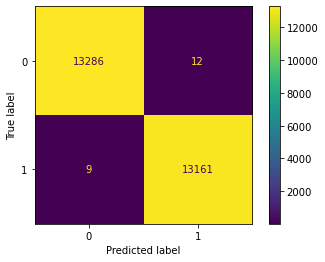

In [80]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(tree_clf, X_test, y_test);

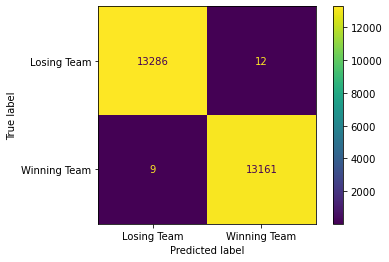

In [81]:
plot_confusion_matrix(tree_clf, X_test, y_test, display_labels=["Losing Team", "Winning Team"])
plt.grid(False);

A confusion matrix is a table that summarizes the performance of a classification algorithm by comparing its 
predicted labels to the true labels. It displays the number of true positives (TP), false positives (FP), 
true negatives (TN), and false negatives (FN) for each class.

In the context of binary classification (i.e., when there are only two classes), a confusion matrix can be 
displayed as follows:

Actual Positive	Actual Negative
Predicted Positive	True Positive (TP)	False Positive (FP)
Predicted Negative	False Negative (FN)	True Negative (TN)
The plot_confusion_matrix() function generates a visual representation of this table using color-coded squares. 
The main diagonal of the matrix represents the correctly classified instances (i.e., the true positives and true 
negatives), while the off-diagonal elements represent the misclassified instances (i.e., the false positives and 
false negatives).

By visualizing the confusion matrix, you can quickly get a sense of how well your classifier is performing, and 
which types of errors it is making. For example, a high number of false positives may indicate that the classifier 
is too aggressive in labeling instances as positive, while a high number of false negatives may indicate that the 
classifier is missing important features that distinguish between the two classes.